<div>
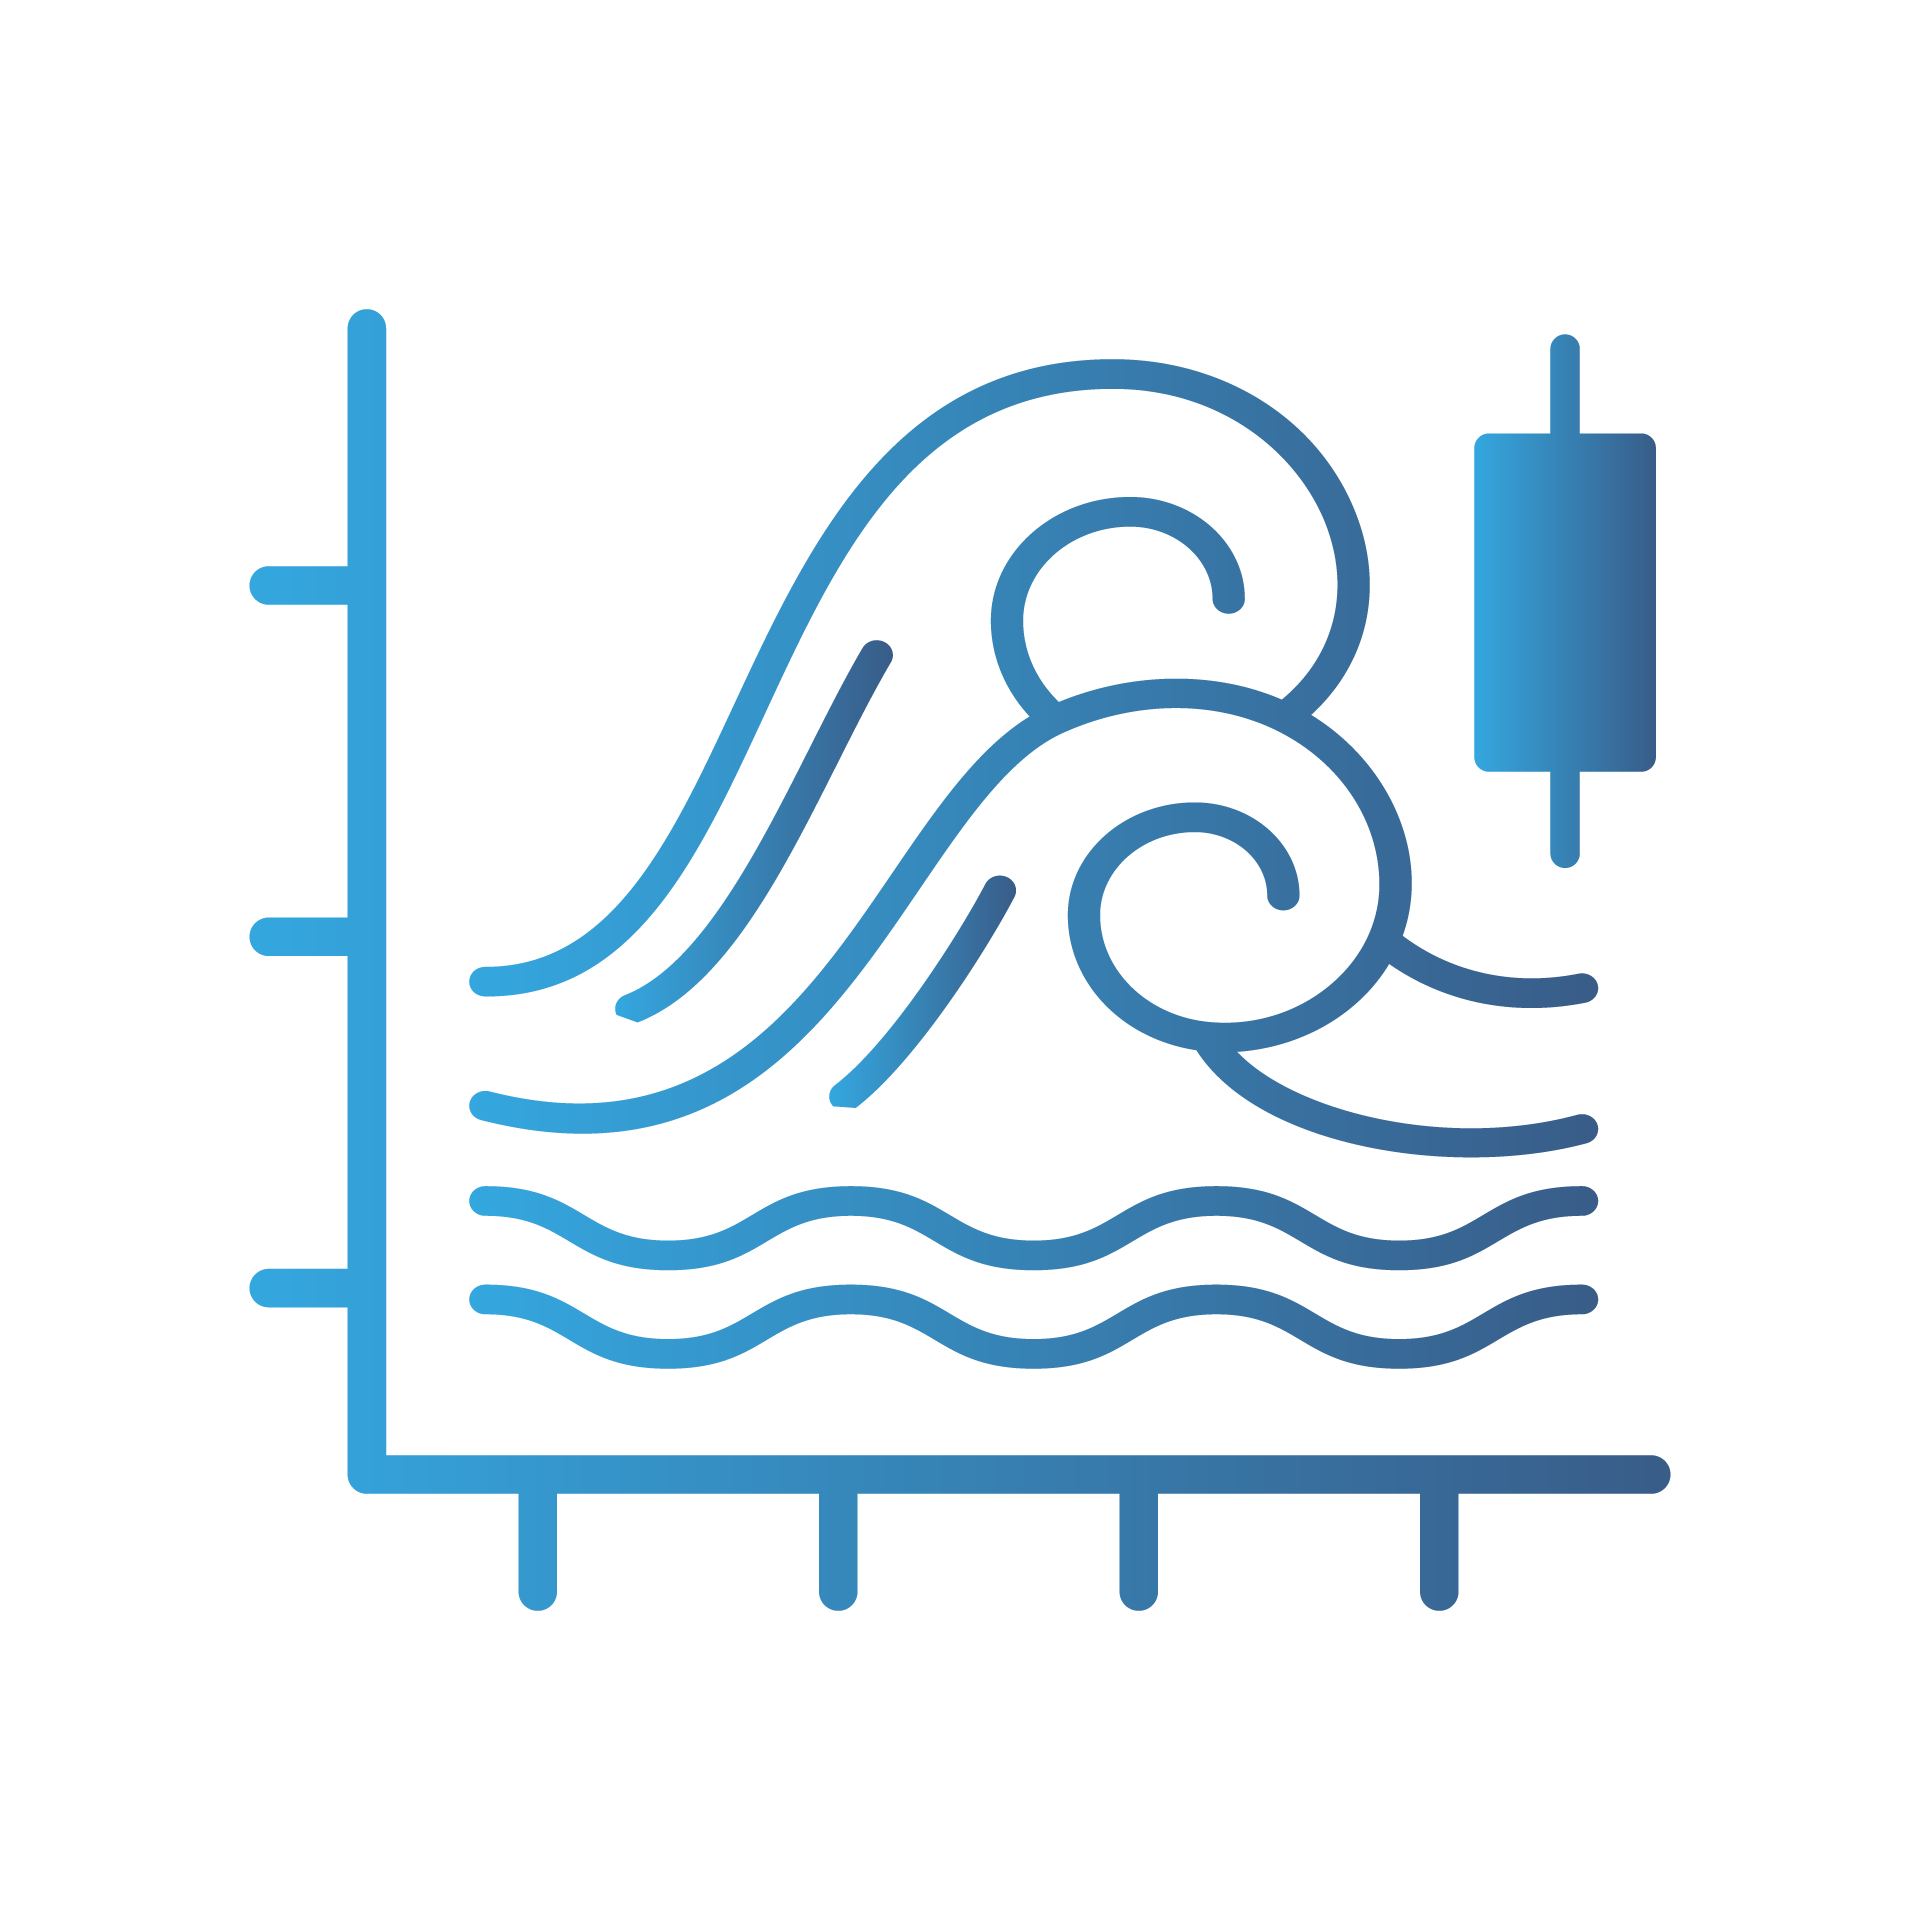
</div>

# __Predict labels with a PCM and plot results__

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr) and Guillaume Maze (gmaze@ifremer.fr)
***

## Description

**The objective of this notebook is to load a PCM model, to classify a dataset (make predictions) and to visualise the results with a collection of plots.**

A PCM (__Profile Classification Model__) allows to automatically, without supervision, assemble ocean profiles into clusters according to their vertical structure similarities. Depending on the dataset, such clusters can show space/time coherence. That is what we call the *ocean patterns indicator*. Clusters will be presented through different plots. For more information about the method, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

As an example, a selection of the ``GLOBAL_REANALYSIS_PHY_001_030`` CMEMS product covering the Mediterranean is used as an input dataset to be classified.

In this notebook we're going to load an existing classification model (PCM). Note thay you can develop, train and optimize a PCM of your own using the notebook ``Develop_PCM_model.ipynb``.

All PCM operations (load, predict) are done using the __pyxpcm python software__ (see documentation at https://pyxpcm.readthedocs.io)


***
This notebook has been developped at Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Blue-Cloud project. Blue-Cloud has received funding from the European Union's Horizon programme call BG-07-2019-2020, topic: [A] 2019 - Blue Cloud services, Grant Agreement n.862409

<div>
<center>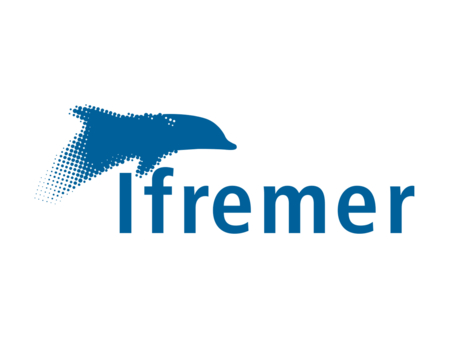 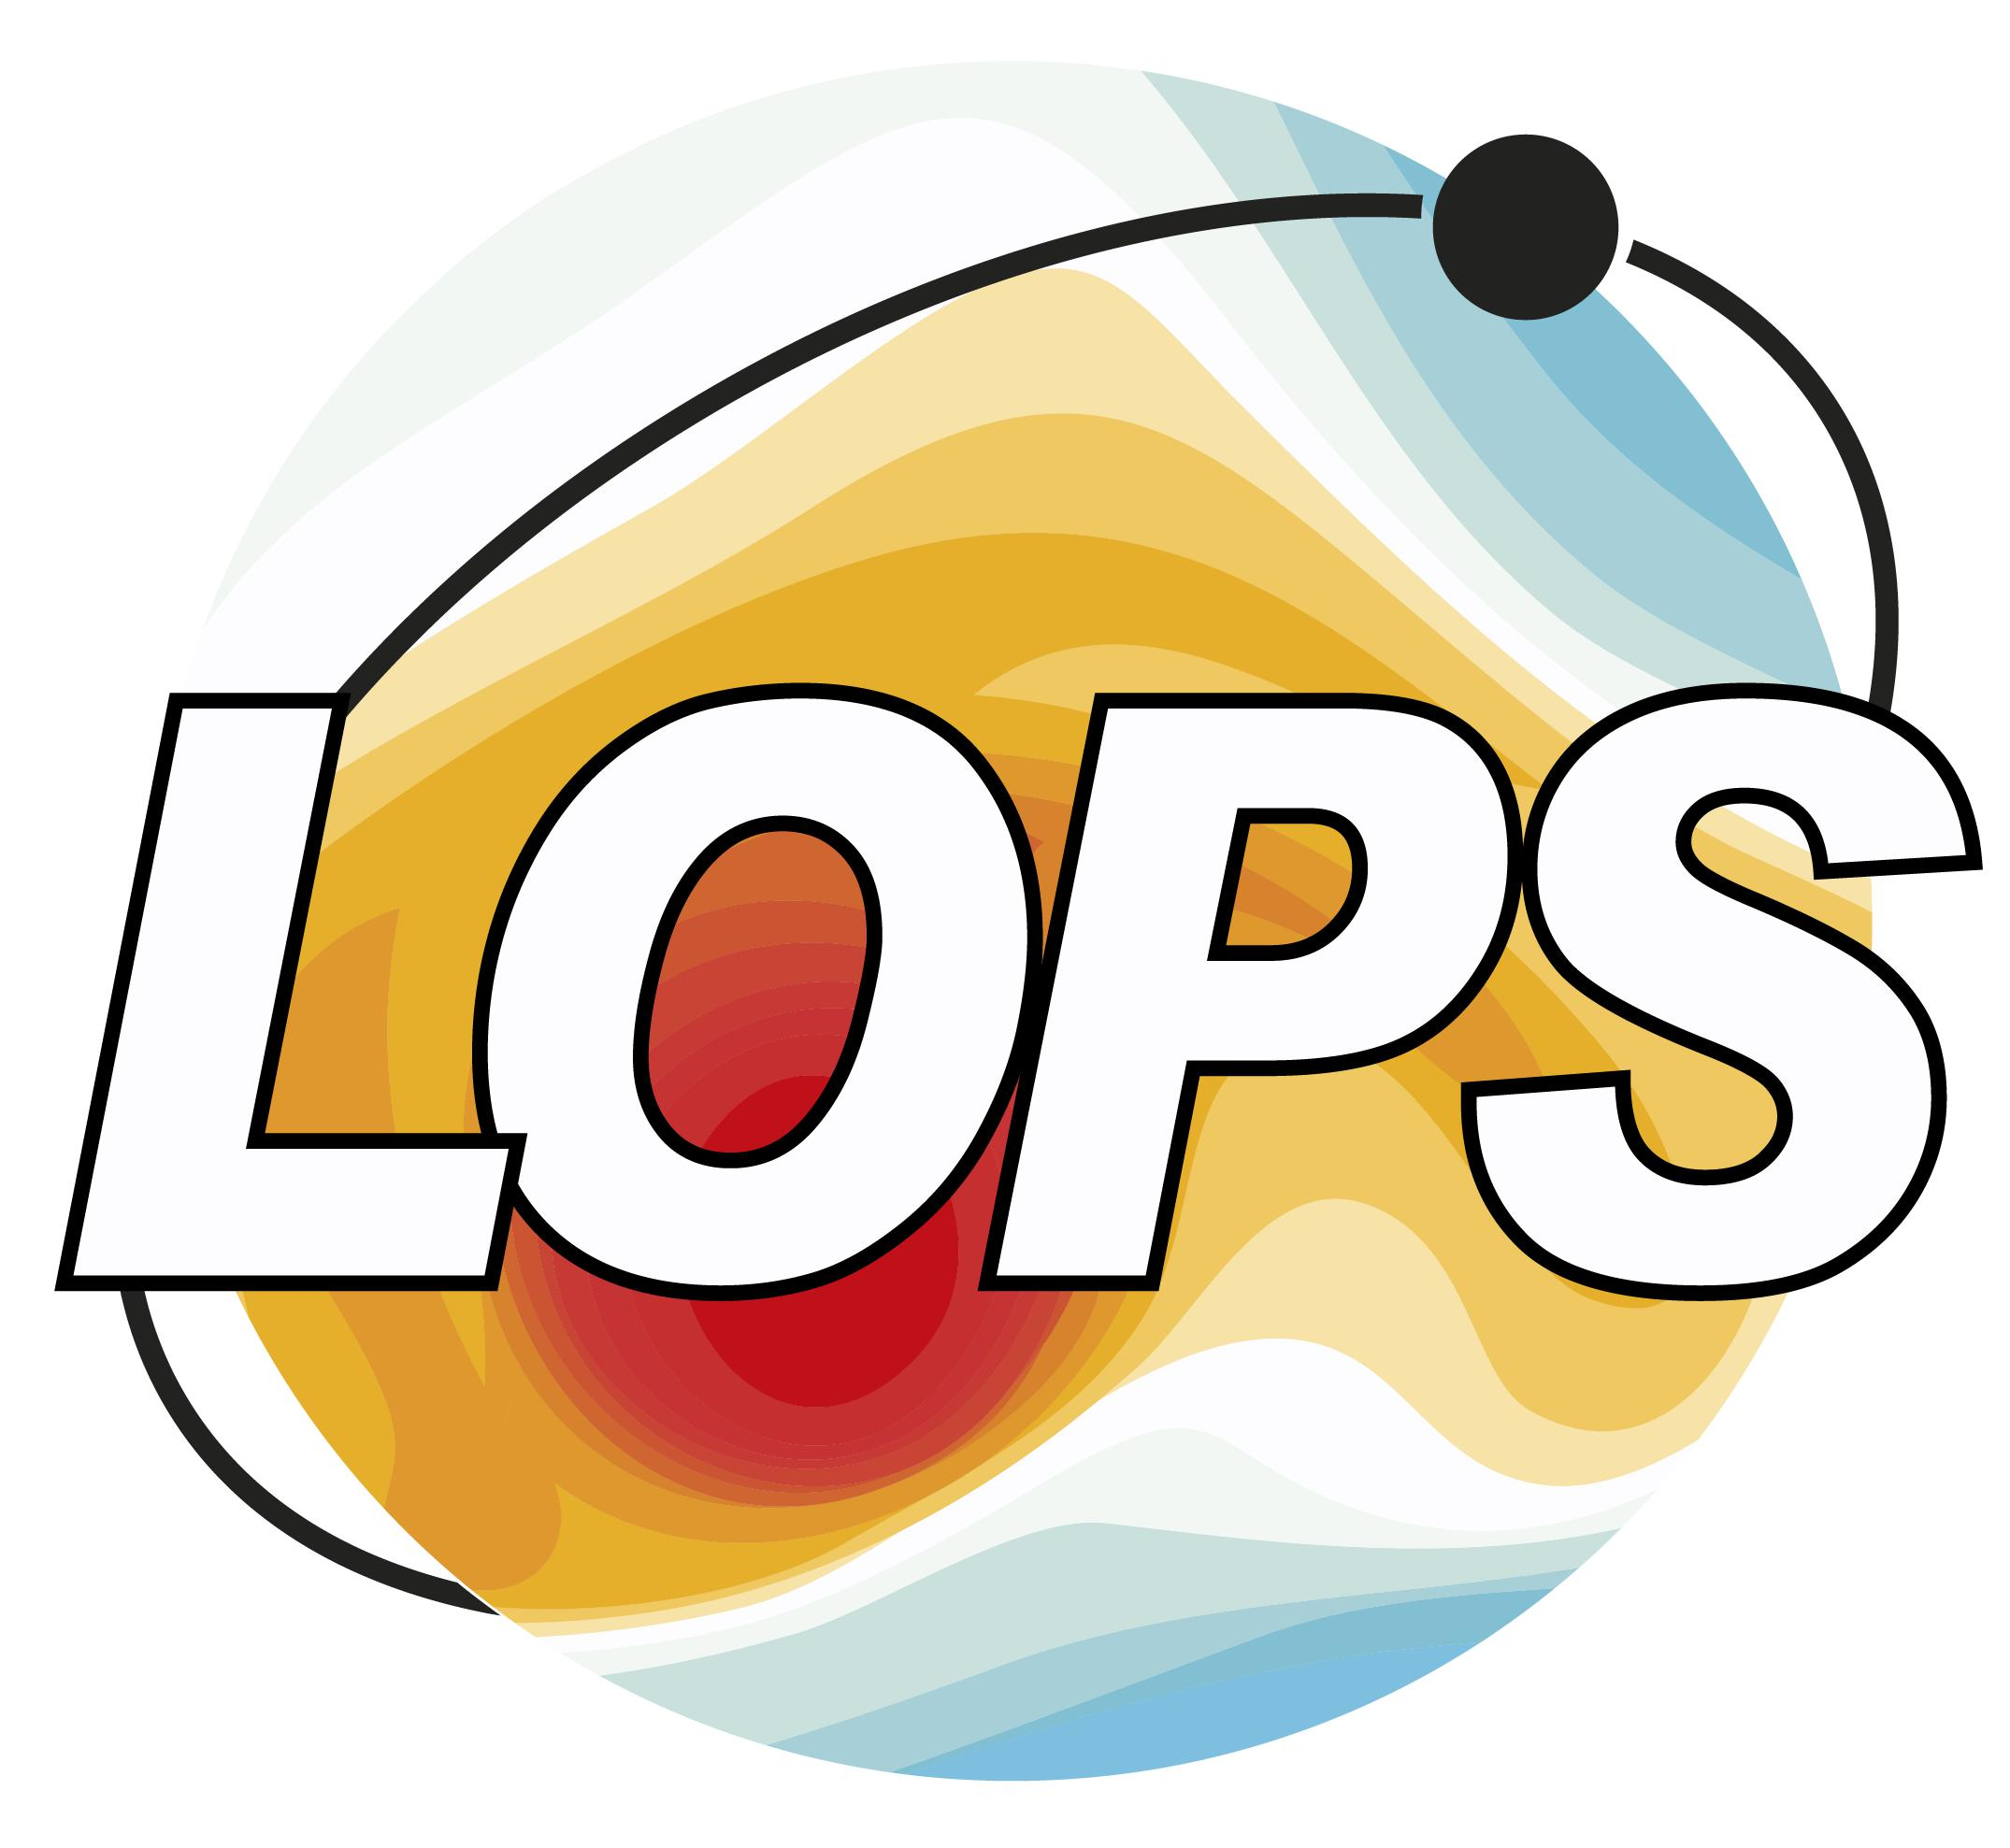 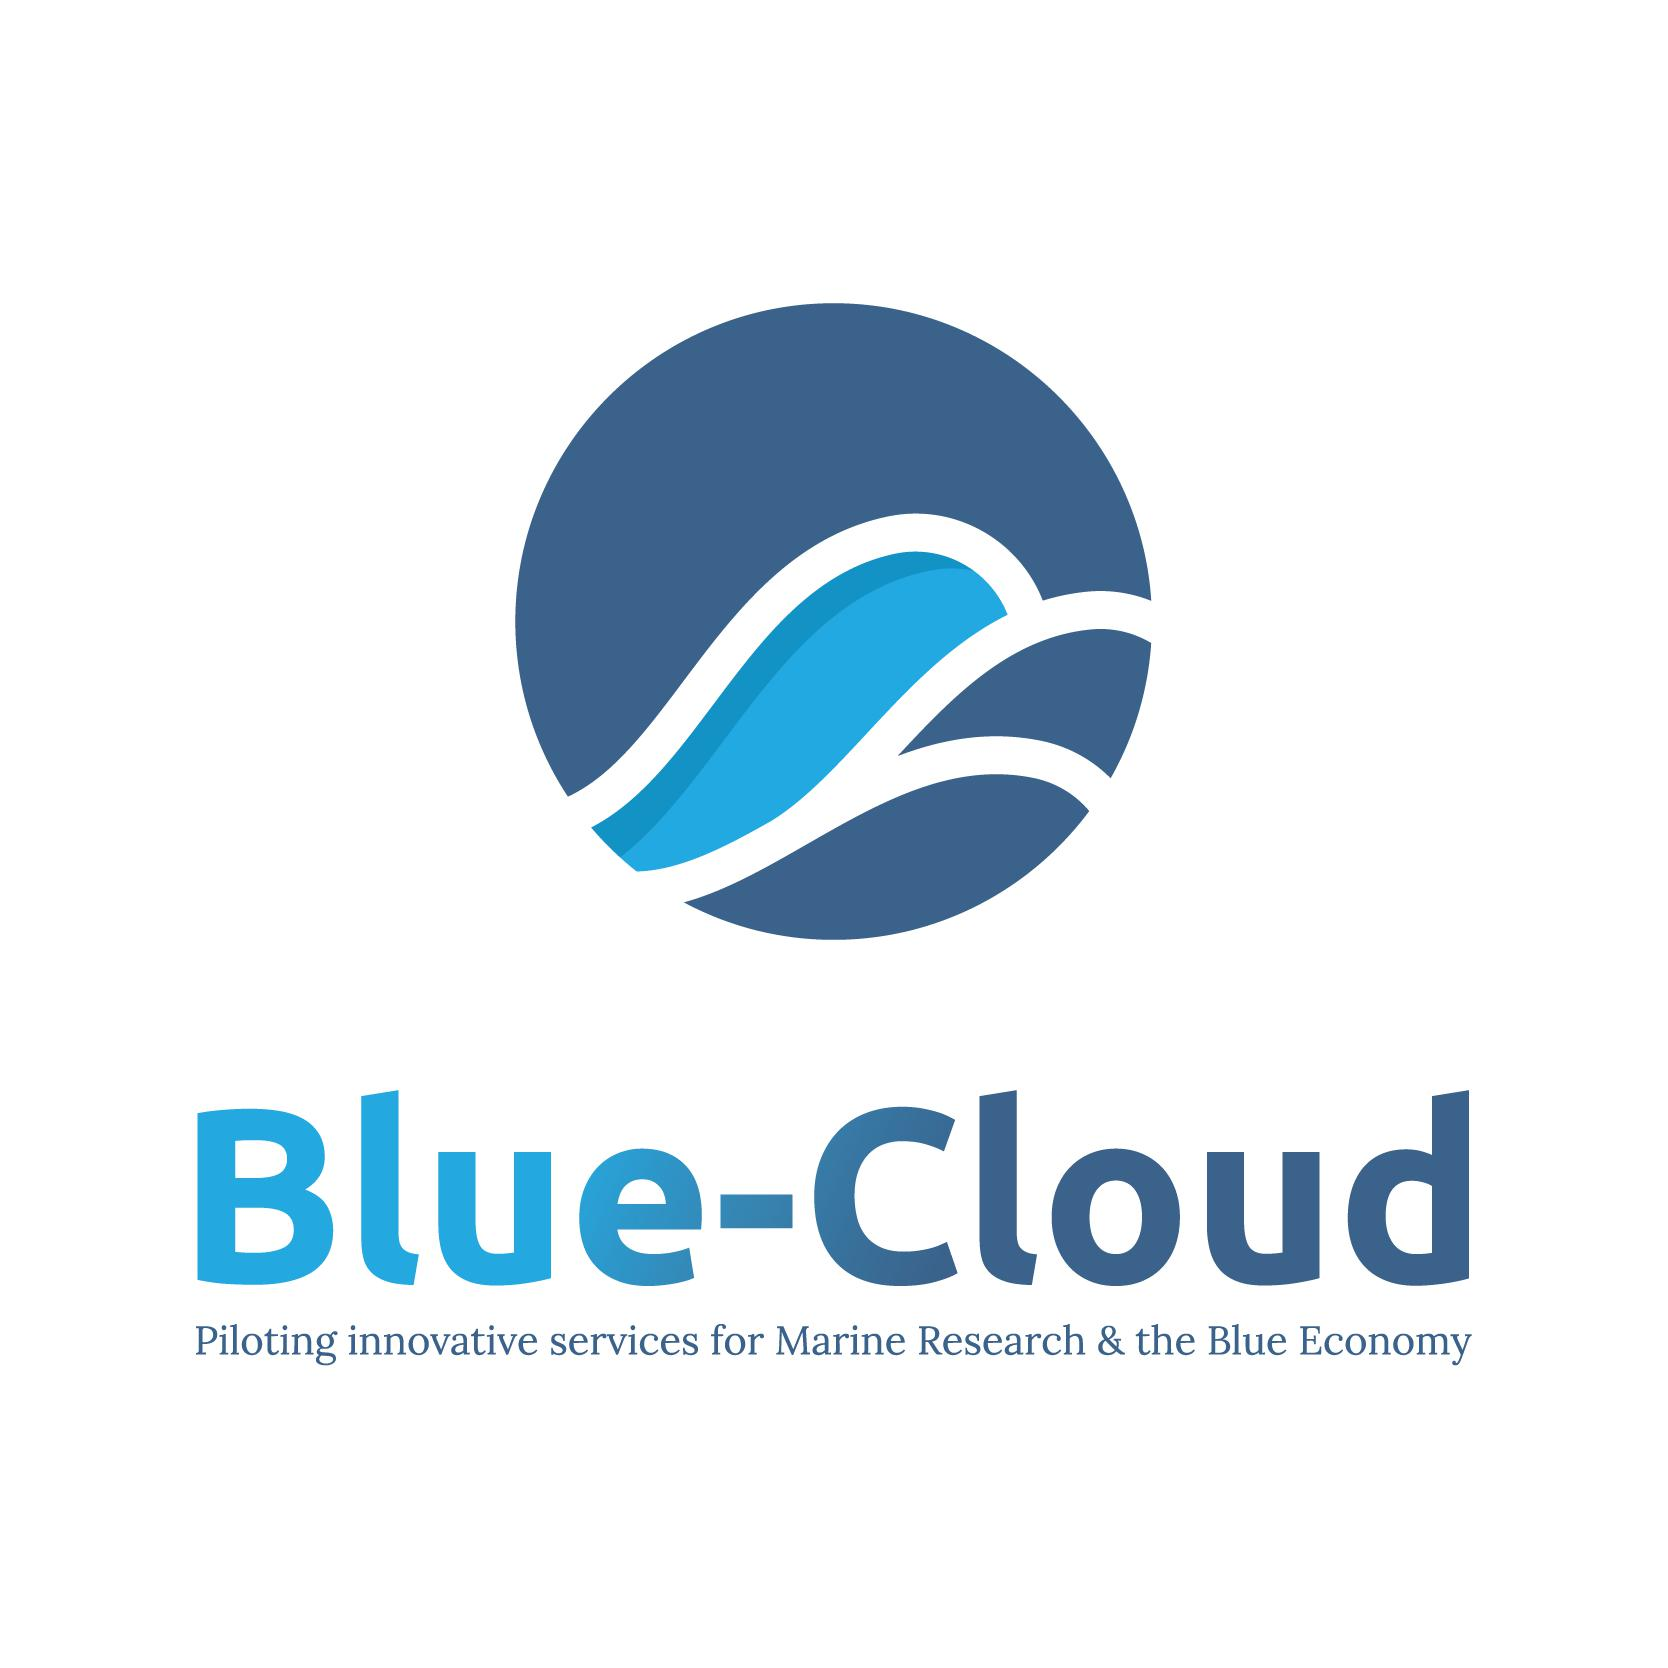</center>
</div>

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

import subprocess

## Load model and dataset
***

In this section you will download the __model__ and the __dataset__ and you should provide some information about them. 

You don't need to use the same dataset you used to train the model for making the prediction of labels. You can, for example, train the model with in-situ data and apply it to a numerical model dataset in order to evaluate the numerical model realism.

__Load model__

You can choose an already trained model, available for you in *models/* folder, or you can design your own model using the ``Develop_PCM_model.ipynb`` notebook. 

In the cell below you should provide tho model path and the name in the model of the variable (feature) to be predict.

In [2]:
# Model path
model_path = 'models/test_model_mediterranean_temp_2018_k8.nc'

# Variable to be predict
var_name_mdl = 'temperature' # name in model

*pyxpcm* library is used to load the chosen model.

In [3]:
m = pyxpcm.load_netcdf(model_path)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 22.753054

In [4]:
m._xlabel

AttributeError: 'pcm' object has no attribute '_xlabel'

__Load dataset__

Dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

You should provide your CMEMS __user name__ and __password__ below.

In [ ]:
CMEMS_user = '#####'
CMEMS_password = '#####'

In [4]:
CMEMS_user = 'agarcia6'
CMEMS_password = '1802910672Aa#'

Data comes from monthly mean fields of the ``GLOBAL_REANALYSIS_PHY_001_030`` product, an eddy-resolving reanalysis with 1/12° horizontal resolution and 50 vertical levels (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030) to get all the infomation about the dataset). 
As an example, we propose to use a selection covering the Mediterranean sea in 2017. The training dataset of the model used in *Develop_PCM_model* notebook was covering 2018, so you will use a different dataset for prediction.

If you feel confident you can modify downloading parameters (cell below) to test other dataset selections than the one we propose here (covering the Mediterranean). You can also test other variables, but do not forget to choose the appropriate model to fit the data. And be careful with memory limits: do not choose very big geographical extents or very long time series.

In [5]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2017-01-01", "2017-12-31"] # ["min date", "max_date"]
# variable to classify (this depends on the PCM being used)
var_name_ds = 'thetao' # name in dataset
# file name
file_name = 'global-reanalysis-phy-001-030-monthly_med_2017.nc'

Dataset is downloaded from __CMEMS__ servers using a Motu client and saved as a __NetCDF__ file in the *datasets/* folder in your work space. Download will take few minutes.

In [6]:
bashCommand = 'python -m motuclient -u "' + CMEMS_user + '" -p "' + CMEMS_password + '" -m "http://my.cmems-du.eu/motu-web/Motu" \
-s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v ' + var_name_ds + ' -o datasets -f ' + file_name
print(bashCommand)
sp = subprocess.call(bashCommand, shell=True)

python -m motuclient -u "agarcia6" -p "1802910672Aa#" -m "http://my.cmems-du.eu/motu-web/Motu" -s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly -x -5 -X 42 -y 30 -Y 46 -t "2017-01-01" -T "2017-12-31" -z 0.0 -Z 2500.0 -v thetao -o datasets -f global-reanalysis-phy-001-030-monthly_med_2017.nc


Finally, the dataset is loaded from the NetCDF file as an *xarray* dataset:

In [7]:
file_path = 'datasets/' + file_name
ds = xr.open_dataset(file_path)

# some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'
z_dim = 'depth'

print(ds)

<xarray.Dataset>
Dimensions:    (depth: 41, latitude: 193, longitude: 565, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -1941.893 -2225.078
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 45.916668 46.0
  * time       (time) datetime64[ns] 2017-01-16T12:00:00 ... 2017-12-16T12:00:00
  * longitude  (longitude) float32 -5.0 -4.9166665 -4.8333335 ... 41.916668 42.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Merc

Quick plot of dataset. Please, choose time and depth slide if needed.

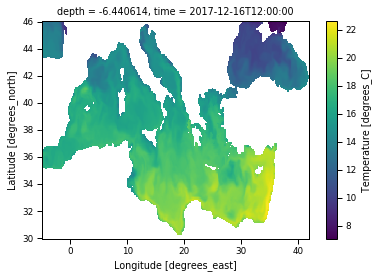

In [8]:
ds[var_name_ds].isel(time=11, depth=5).plot();

## Predict labels
***

Results of the PCM classification (e.g. labels and some other statistics) are computed using the *pyxpcm* library. 
These new variables are simply added to the dataset (`inplace=True` option). Note that you can aggregate classification results in another *xarray* dataset if you wish.

__Predict class labels__

The trained PCM instance (here called ``m``) contains all the necessary information to classify profiles from the dataset we just loaded.
Each profiles in this dataset will be attributed (__predicted__) to one of the PCM classes. A new variable *PCM_LABELS* is created to host this result in the dataset ``ds``.

In [9]:
features_in_ds = {var_name_mdl: var_name_ds}
m.predict(ds, features=features_in_ds, dim=z_dim, inplace=True);

__Probability of a profile to be in a class__

As the *pyxpcm* software is using the fuzzy classifier GMM ([Gaussian Mixture Model](https://scikit-learn.org/stable/modules/mixture.html)) by default, it is possible to calculate the probability of a profile to belong to a class, also called __posterior__. This is the first step to determine the robustness of the classification with this PCM, which will be calculated below. A new variable *PCM_POST* is created.

In [10]:
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);

__Classes quantiles__

Class vertical structure can be represented using the quantiles of all profiles corresponding to a class. We advise you to calculate at least the __median profile__ and the 5% and 95% quantiles (`q=[0.05, 0.5, 0.95]`) to have a minimal representation of the classes, but feel free to add other quantiles if you want. A new variable `outname=var_name_ds + '_Q'` is added to the dataset.

In [11]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds, outname=var_name_ds + '_Q', keep_attrs=True, inplace=True)

__Robustness__

The classification robustness is a scaled version of the __probability__ of a profile to belong to a class (i.e. the posteriors) so that the value range is more appropriate to assess the **robustness** of a classification. 
A 0 value indicates the PCM is totally unsure of the classification result (all classes are equiprobable), while values close to 1 indicate the PCM is highly confident of the result. 
Note that this does not prevail the scientific mean of the classification, but rather indicates the ability of the PCM to attribute a profile to a specific class with confidence.

Two new variables are added to the dataset: *PCM_ROBUSTNESS* and *PCM_ROBUSTNESS_CAT*. The 2nd variable is categorical and is based on the IPCC likelihood scale:

| Robustness range | Category          |
|------------------|-------------------|
| 0-33%            | Unlikely          |
| 33%-66%          | As likely as not  |
| 66%-90%          | Likely            |
| 90%-99%          | Very likely       |
| 99%-100%         | Virtually certain |

In [12]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (depth: 41, latitude: 193, longitude: 565, pcm_class: 8, quantile: 3, time: 12)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7
  * depth               (depth) float32 -0.494025 -1.541375 ... -2225.078
  * latitude            (latitude) float64 30.0 30.08 30.17 ... 45.83 45.92 46.0
  * time                (time) datetime64[ns] 2017-01-16T12:00:00 ... 2017-12-16T12:00:00
  * longitude           (longitude) float64 -5.0 -4.917 -4.833 ... 41.92 42.0
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    thetao              (time, depth, latitude, longitude) float32 nan ... nan
    PCM_LABELS          (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_POST            (pcm_class, time, latitude, longitude) float64 nan ... nan
    thetao_Q            (pcm_class, quantile, depth) float64 19.69 ... 13.6
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 5 5 5 5 5 ... 5 5 5 5
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Plot results
***

Plots are created using the *Plotter* class, which is instantiated below. Plots include the vertical structure and the spatial and the temporal distribution of classes. These plots will allow you to determine if classes show a spatial or temporal coherence: the __ocean patterns indicator__.

The ``save_BlueCloud`` function saves the figure and add dataset information and logos below. 

Please, feel free to change plot options if you need it.

In [13]:
P = Plotter(ds, m)

#### __1. Vertical structure of classes__

The graphic representation of quantile profiles reveals the vertical structure of each classes. 
These different vertical structures are the fondation of the PCM, the "distance" of a profile to each of the typical vertical structures controls the classification outcome. 
The median profiles will give you the best idea of the __typical profile__ of a class and the other quantiles, the possible __spread__ of profiles within a class. It is with the spread that you can determine if a class has captured a homogeneous water mass (small spread) or a layer with gradients (large spread, like a thermocline for instance).

In [ ]:
P.vertical_structure(q_variable = var_name_ds + '_Q', sharey=True, xlabel='Temperature (°C)')
P.save_BlueCloud('figures/vertical_struc_EX.png')

Quantiles can also be plotted __together__ to highlight differences between classes. Using `plot_q` option you can choose the quantiles you want to plot together.

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds + '_Q', plot_q= 'all', xlabel='Temperature (°C)', ylim=[-1000,0])
P.save_BlueCloud('figures/vertical_struc_comp_EX.png')

#### __2. Spatial distribution of classes__

You can also plot the PCM labels in a map to analyse the spatial coherence of classes. The spatial information (coordinates) of profiles is not used to fit the model, so spatial coherence appears naturally, reveling vertical structure similarities between different areas of the ocean. If you detect any spatial coherence, well done, you have found a __ocean pattern indicator__!.

As the dataset is a time series you should choose the time slice to use in the plotting function below:

Figure saved in figures/spatial_distr_EX.png


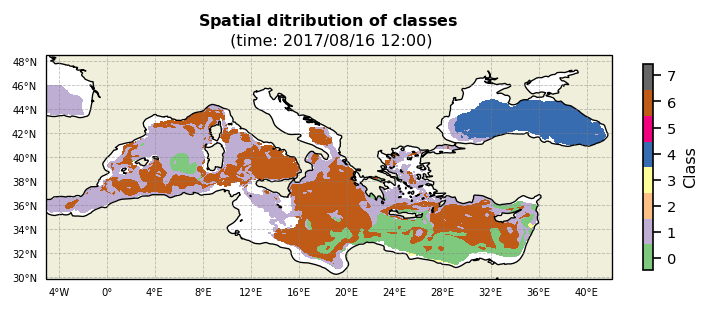

In [14]:
P.spatial_distribution(time_slice="2017-08")
P.save_BlueCloud('figures/spatial_distr_EX.png')

If you want a more synthtetic view of the classification result over time, you can plot, for each pixel, the __most frequent class label__, using the option `time_slice='most_freq_label'`.

In [ ]:
P.spatial_distribution(time_slice='most_freq_label')
P.save_BlueCloud('figures/spatial_distr_freq_EX.png')

#### __3. Robustness__

Robustness is a scaled __probability__ of a profile to belong to a class. 
When looking at the spatial distribution of the robustness metric, and if classes have a spatial structure, you may encounter regions with low probabilities between classes: these indicate a **smooth** transition between the structures, i.e. these transition regions are likely not associated with a front but rather with continuous structures. On the other hand, if the robustness metric is fairly high on the edges of classes, this is an indication that a frontal structure may be marking the **sharp** limit (in space) between the classes.
You can find an example of this type of structure transitions for the North Atlantic ocean in [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

You should still chose the `time_slice` option in the plotting  function below, as example dataset is a time series.

Figure saved in figures/robustness_EX.png


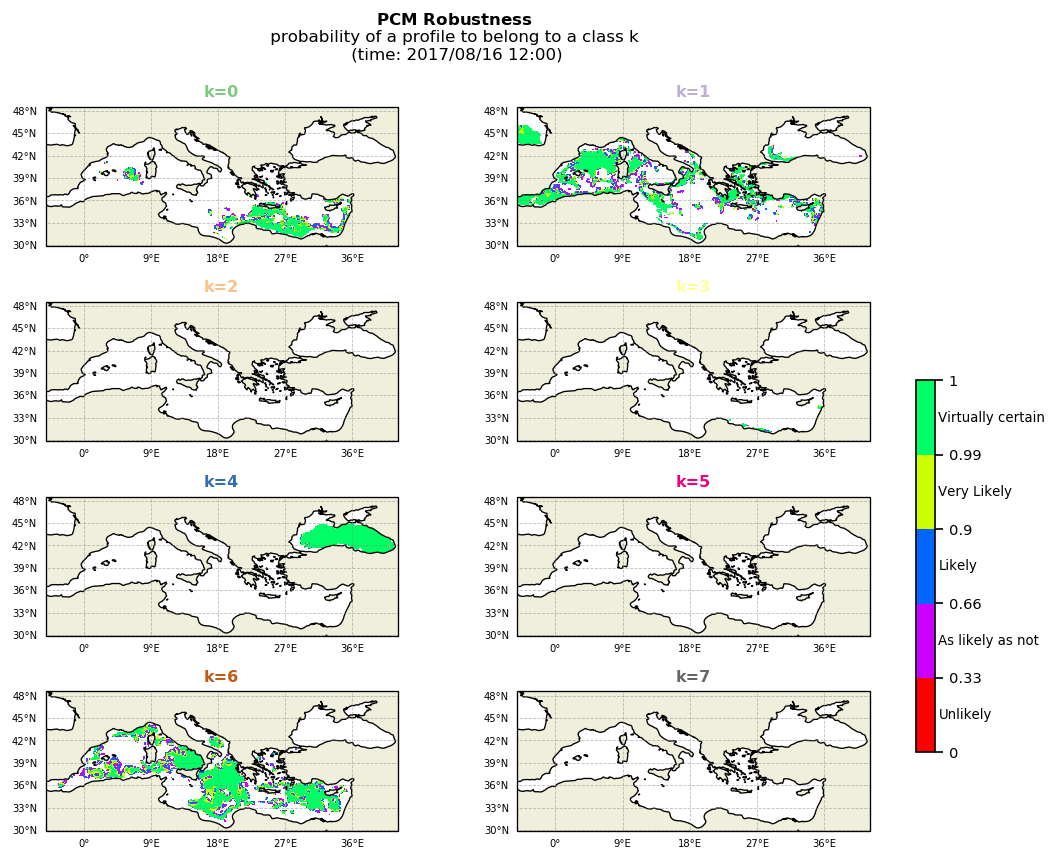

In [15]:
P.plot_robustness(time_slice="2017-08")
P.save_BlueCloud('figures/robustness_EX.png')

#### __4. Classes pie chart__

Here you can plot a pie chart showing the percentage of profiles belonging to each class and the number of classified profiles.

In [ ]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX.png')

#### __4. Temporal representation__ 

The bar plots below represents the percentage of profiles in each class by month and by season. These plots can unfold underlying temporal coherence between classes: some classes can be more important in summer or in winter periods. Coherence is revealed naturally by ocean structures, since time was not used to fit the PCM model. If you find temporal coherence, well done, you have found the __Ocean Pattern Indicator__.

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_bins = 'month')
P.save_BlueCloud('figures/temporal_distr_months_EX.png')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_bins = 'season')
P.save_BlueCloud('figures/temporal_distr_season_EX.png')

## Save data
***

If you are happy with the results and you want to work on the data by your own, you can save the dataset including the new PCM variables (PCM labels, robustness, …) in the cell below.

In [ ]:
ds.to_netcdf('datasets/mediterranean_2017_temp_predicted_dataset.nc')

In [ ]:
ds

In [ ]:
ds.PCM_ROBUSTNESS_CAT.min()